In [ ]:
import sys
print(sys.executable)

/home/swift/.virtualenvs/cv/bin/python


In [ ]:
import math
import numpy as np
import time
import scipy.sparse as ss
import scipy.sparse.linalg as ssl

#import pylab 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
###############################
# convert.py
###############################

def mat2vec(mat):
    vec = np.mat(np.zeros((3, 1))) # 3x1 matrix with all zeros
    vec[0, 0] = mat[0, 2] # x
    vec[1, 0] = mat[1, 2] # y
    vec[2, 0] = math.atan2(mat[1, 0], mat[0, 0]) # yaw = atan(sin(yaw)/cos(yaw))
    
    return vec
    
    
def vec2mat(vec):
    if vec.shape != (3, 1):
        print 'vec is not 3*1 matrix'
        return 0
    
    c = math.cos(vec[2, 0])
    s = math.sin(vec[2, 0])
    
    mat = np.mat([
        [c, -s, vec[0,0]], # [cos(yaw) -sin(yaw) x]
        [s,  c, vec[1,0]], # [sin(yaw)  cos(yaw) y]
        [0,  0,        1]  # [   0         0     1]
    ])
    
    return mat

In [ ]:
###############################
# PoseNode class
###############################

class PoseNode(object):
    def __init__(self, Id, pose):
        self.Id = Id
        self.pose = np.mat(pose).T # 3x1 matrix
        self.x = self.pose[0, 0]
        self.y = self.pose[1, 0]
        self.yaw = self.pose[2, 0]
        #self.rt = v2t(self.pose) # 3x3 matrix

In [ ]:
###############################
# PoseEdge class
###############################

class PoseEdge(object):
    def __init__(self, Id_from, Id_to, mean, info_matrix):
        self.Id_from = Id_from
        self.Id_to = Id_to
        self.mean = np.mat(mean).T # 3x1 matrix 
        self.info_matrix = info_matrix

In [ ]:
###############################
# PoseGraph class
###############################

def id2idx(Id):
    #ind = [(3*Id), (3*(Id+1))]
    idx = [3*Id, 3*(Id+1)]
    return idx


class PoseGraph(object):
    
    def __init__(self):
        self.node = [] # Pose nodes in graph
        self.edge = [] # Edge in graph
        
        
    def readGraph(self, vertex_file, edge_file):
        with open(vertex_file, 'r') as f:
            for line in f.readlines():
                a = line.strip().split(' ')     # e.g. ['VERTEX2', '0', '1.008240', '-0.016781', '0.005957']
                vi = [float(x) for x in a[1:]] # e.g. [0.0, 1.00824, -0.016781, 0.005957]
                Id = vi[0]     # e.g. 0.0
                pose = vi[1:4] # e.g. [1.00824, -0.016781, 0.005957]
                
                self.node.append(PoseNode(Id, pose))
            #endfor
        #endwith
        
        self.n_node = len(self.node)
        print 'Verices loaded from: ', vertex_file
        
        with open(edge_file, 'r') as f:
            for line in f.readlines():
                a = line.strip().split(' ')          # e.g. ['EDGE2', '1', '0', '-1.082078', '-0.007851', '-0.009693', '20.000000', '0.000000', '20.000000', '100000.000', '0.000000', '0.000000']
                edge_ij = [float(x) for x in a[1:]] # e.g. [1.0, 0.0, -1.082078, -0.007851, -0.009693, 20.0, 0.0, 20.0, 100000.0, 0.0, 0.0]
                Id_from = edge_ij[0] # e.g. 1.0
                Id_to = edge_ij[1]   # e.g. 0.0
                mean = edge_ij[2:5]  # e.g. [-1.082078, -0.007851, -0.009693]
               
                info_matrix = np.mat([
                    [edge_ij[5], edge_ij[6],  edge_ij[9] ], # e.g. [2.e+01 0.e+00 0.e+00]
                    [edge_ij[6], edge_ij[7],  edge_ij[10]], # e.g. [0.e+00 2.e+01 0.e+00]
                    [edge_ij[9], edge_ij[10], edge_ij[8] ]  # e.g. [0.e+00 0.e+00 1.e+05]
                ])
                
                self.edge.append(PoseEdge(Id_from, Id_to, mean, info_matrix))
            #endfor
        #endwith
        
        self.n_edge = len(self.edge)
        print 'Edges loaded from: ', edge_file
                
            
    def linearize(self):
        print 'Initializing H (informatin matrix) and b (information vector)...'
        self.H = np.mat(np.zeros((self.n_node*3, self.n_node*3)))
        self.b = np.mat(np.zeros((self.n_node*3, 1)))
            
        for edge_ij in self.edge:
            Id_i = edge_ij.Id_from # e.g. 1.0
            Id_j = edge_ij.Id_to   # e.g. 0.0
            i_idx = id2idx(int(Id_i)) # e.g. [3, 6]
            j_idx = id2idx(int(Id_j)) # e.g. [0, 3]
            
            node_i = self.node[int(Id_i)].pose # e.g. [[2.090063], [0.008002],  [0.015650]] # 3x1 matrix
            node_j = self.node[int(Id_j)].pose # e.g. [[1.008240], [-0.016781], [0.005957]] # 3x1 matrix
            
            # Local information matrix `Omega`
            Omega = edge_ij.info_matrix # 3x3 matrix
            
            # Pose representation matrix `X_i` and
            # Rotation matrix `R_i` on Vehicle_i coordinate
            X_i = vec2mat(node_i) # 3x3 matrix
            R_i = X_i[0:2, 0:2]   # 2x2 matrix
            
            # Pose representation matrix `X_j` on Vehicle_j coordinate
            X_j = vec2mat(node_j) # 3x3 matrix
            
            # Observation representation matrix `Z_ij` and
            # Rotation matrix `R_ij` on Vehicle_j coordinate
            Z_ij = vec2mat(edge_ij.mean) # 3x3 matrix
            R_ij = Z_ij[0:2, 0:2]        # 2x2 matrix
            
            # Error between edges `e`
            e = mat2vec(Z_ij.I * X_i.I * X_j) # 3x1 matrix
             
            s_i = X_i[1, 0] # sin(yaw_i)
            c_i = X_i[0, 0] # cos(yaw_i)
            
            # Differentail of `R_i` ... d(R_i)/d(yaw_i)
            dR_dyaw_i = np.mat([   
                [-s_i, -c_i],
                [c_i,  -s_i]
            ])
            
            # Robot position vector `t_i`, `t_j`
            t_i = node_i[0:2, 0] # 2*1 matrix, [x_i, y_i]
            t_j = node_j[0:2, 0] # 2*1 matrix, [x_j, y_j]
            
            # Separated Jacobian matrix `A_ij` which is regarding to `x_i`
            A = np.mat(np.zeros((3, 3))) # 3x3 matrix with all zeros
            A[0:2, 0:2] = -R_ij.T * R_i.T                    # Top left 2x2 elements
            A[0:2, 2:3] = R_ij.T * dR_dyaw_i.T * (t_j - t_i) # Top right 2x1 elements
            A[2:3, 0:3] = np.mat([0, 0, -1])                 # Bottom 1x3 elements
            
            # Separated Jacobian matrix `B_ij` which is regarding to `x_j`
            B = np.mat(np.zeros((3, 3))) # 3x3 matrix with all zeros
            B[0:2, 0:2] = R_ij.T * R_i.T    # Top left 2x2 elements
            B[0:2, 2:3] = np.mat([0, 0]).T  # Top right 2x1 elements
            B[2:3, 0:3] = np.mat([0, 0, 1]) # Bottom 1x3 elements
            
            # Information sub-matrix of the system `H_ii`, `H_ij`, `H_ji`, `H_jj`
            H_ii = A.T * Omega * A;    H_ij = A.T * Omega * B
            H_ji = B.T * Omega * A;    H_jj = B.T * Omega * B
          
            # Adding the sub-matrix into the information matrix of the system `H`
            self.H[i_idx[0]:i_idx[1], i_idx[0]:i_idx[1]]+=H_ii;  self.H[i_idx[0]:i_idx[1], j_idx[0]:j_idx[1]]+=H_ij
            self.H[j_idx[0]:j_idx[1], i_idx[0]:i_idx[1]]+=H_ji;  self.H[j_idx[0]:j_idx[1], j_idx[0]:j_idx[1]]+=H_jj
            
            # Information sub-vector of the system `b_i`,`b_j`
            b_i = A.T * Omega * e
            b_j = B.T * Omega * e
            
            # Adding the sub-vector into the information vector of the system `b`
            self.b[i_idx[0]:i_idx[1]] += b_i
            self.b[j_idx[0]:j_idx[1]] += b_j
        

    def solve(self):
        print 'Pose: ', self.n_node, 'Edge: ', self.n_edge
        
        # Add an Identity matrix to fix the first pose, `x0` and `y0`, as the origin
        self.H[0:3, 0:3] += np.eye(3)
        
        # Make copy of H to prevent overwriting original H
        H = self.H.copy()
        
        # Make sparse matrix of `H`
        #H_sparse = scipy.sparse.csc_matrix(H)
        H_sparse = ss.csc_matrix(H) # 3`n_node`x3`n_node` matrix
        
        # `H`^-1
        #H_sparse_inv = scipy.sparse.linalg.splu(H_sparse)
        H_sparse_inv = ssl.splu(H_sparse)
        
        # `dx` = -`H`^-1 * `b`
        dx = -H_sparse_inv.solve(self.b) # 3`n_node`x1 matrix
        
        # Reshape
        dx = dx.reshape([3, self.n_node], order='F')  # 3x`n_node` matrix
        
        # Update
        for i in range(self.n_node):
            self.node[i].pose += dx[:, i]
        
        
    def optimize(self, n_iter=1, visualize=False):
        for i in range(n_iter):
            print 'Pose Graph Optimization, Iteration ', i+1
            
            print 'Linearizing...'
            self.linearize()
            
            print 'Solving...'
            self.solve()
            
            print 'Iteration', i+1, 'done.'
            
            # Visualize
            if visualize:
                plt.clf()
                x = [each_node.pose[0,0] for each_node in self.node]
                y = [each_node.pose[1,0] for each_node in self.node]
                plt.plot(x, y)
                plt.title('Iteration %d' %(i+1))
                plt.show()

In [ ]:
A = np.mat([
    [-0.99998226, -0.00595696, -0.01833818],
    [ 0.00595696, -0.99998226,  1.08195144],
    [ 0.,          0.,         -1.        ]
])

B = np.mat([
    [ 0.99998226,  0.00595696,  0.        ],
    [-0.00595696,  0.99998226,  0.        ],
    [ 0.,          0.,          1.        ]
])

Omega = np.mat([
    [2.e+01, 0.e+00, 0.e+00],
    [0.e+00, 2.e+01, 0.e+00],
    [0.e+00, 0.e+00, 1.e+05]
])

print 'H_ij.T = '
print '(A.T * Omega * B).T = \n', (A.T * Omega * B).T
print
print 'B.T * (A.T * Omega).T = \n', B.T * (A.T * Omega).T
print
print '--------------------------------------------------'
print
print 'B.T * Omega.T * A.T.T = \n', B.T * Omega.T * A.T.T
print
print 'B.T * Omega * A = \n', B.T * Omega * A

H_ij.T = 
(A.T * Omega * B).T = 
[[-2.00000001e+01 -3.14350663e-18 -4.95659923e-01]
 [ 2.97130044e-18 -2.00000001e+01  2.16364601e+01]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+05]]

B.T * (A.T * Omega).T = 
[[-2.00000001e+01 -3.14350663e-18 -4.95659923e-01]
 [ 2.97130044e-18 -2.00000001e+01  2.16364601e+01]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+05]]

--------------------------------------------------

B.T * Omega.T * A.T.T = 
[[-2.00000001e+01  2.97130044e-18 -4.95659923e-01]
 [-3.14350663e-18 -2.00000001e+01  2.16364601e+01]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+05]]

B.T * Omega * A = 
[[-2.00000001e+01  2.97130044e-18 -4.95659923e-01]
 [-3.14350663e-18 -2.00000001e+01  2.16364601e+01]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+05]]


Verices loaded from:  data/killian-v.dat
Edges loaded from:  data/killian-e.dat
Pose Graph Optimization, Iteration  1
Linearizing...
Initializing H (informatin matrix) and b (information vector)...
Solving...
Pose:  1941 Edge:  3995
Iteration 1 done.


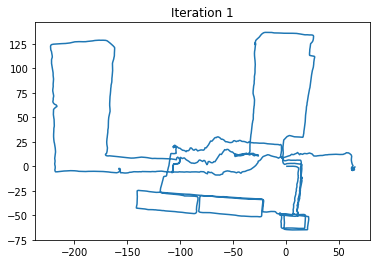

Pose Graph Optimization, Iteration  2
Linearizing...
Initializing H (informatin matrix) and b (information vector)...
Solving...
Pose:  1941 Edge:  3995
Iteration 2 done.


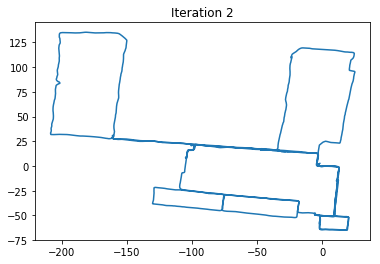

Pose Graph Optimization, Iteration  3
Linearizing...
Initializing H (informatin matrix) and b (information vector)...
Solving...
Pose:  1941 Edge:  3995
Iteration 3 done.


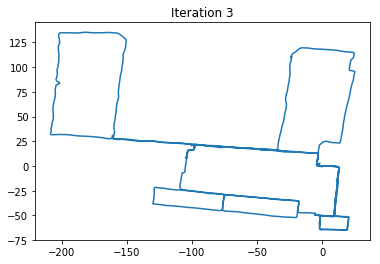

Pose Graph Optimization, Iteration  4
Linearizing...
Initializing H (informatin matrix) and b (information vector)...
Solving...
Pose:  1941 Edge:  3995
Iteration 4 done.


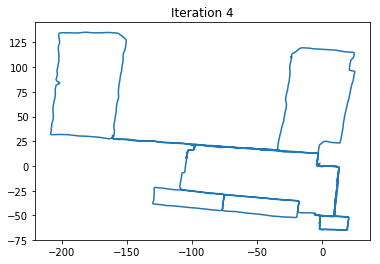

Pose Graph Optimization, Iteration  5
Linearizing...
Initializing H (informatin matrix) and b (information vector)...
Solving...
Pose:  1941 Edge:  3995
Iteration 5 done.


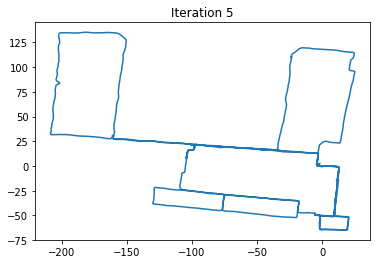

In [ ]:
##############################
# Main loop
###############################

vertex_file='data/killian-v.dat'
edge_file='data/killian-e.dat'

pg=PoseGraph()
pg.readGraph(vertex_file, edge_file)
pg.optimize(5, True)